# AI Evaluation Workshop: Building Trust in Automated Judgment

This notebook teaches you to build, validate, and monitor AI evaluation pipelines using a mortgage lending assistant as our running example. By the end, you'll have a framework for answering the question every stakeholder asks: **"How do we know the AI is doing a good job?"**

**Key insight:** Governance is an accelerator, not a gate. Confidence in automated evaluation comes from systematically comparing machine judgment against human judgment.

| Section | Topic | What You'll Build |
|---------|-------|-------------------|
| 1 | Assertions & Basic deepeval | RAG pipeline + generic quality metrics |
| 2 | Custom Metrics | Domain-specific GEval metrics for compliance & actionability |
| 3 | Golden Dataset | Acceptance criteria with positive and negative examples |
| 4 | Inter-Rater Reliability | Cohen's kappa — does the machine agree with the human? |
| 5 | Multiple Evaluators | Pairwise and Fleiss' kappa across a team |
| 6 | Production Monitoring | Improvement loops and governance framework |

**Requirements:** Python 3.12+, Anthropic API key in `.env`, packages from `requirements.txt`

In [1]:
import os
from dotenv import load_dotenv

# Opt out of deepeval telemetry before any deepeval imports
os.environ["DEEPEVAL_TELEMETRY_OPT_IN"] = "NO"

# Load API key from .env
load_dotenv()

api_key = os.getenv("ANTHROPIC_API_KEY")
if not api_key:
    raise EnvironmentError(
        "ANTHROPIC_API_KEY not found. "
        "Create a .env file in this directory with: ANTHROPIC_API_KEY=sk-ant-..."
    )

print(f"API key loaded: {api_key[:12]}...{api_key[-4:]}")
print("Environment ready.")

API key loaded: sk-ant-api03...XQAA
Environment ready.


---
## Section 1: Assertions and Basic deepeval

If you've written unit tests, you already understand AI evaluation. The concepts map directly:

| Classical Testing | AI Evaluation |
|-------------------|---------------|
| Unit test | Single test case (input + expected output) |
| Assertion | Metric pass/fail (e.g., is the response faithful?) |
| Test suite | Evaluation dataset |
| Regression test | Golden dataset comparison |
| Code coverage | Metric coverage across quality dimensions |

The difference: instead of checking exact equality (`assertEqual`), we use **LLM-as-judge** metrics that produce **binary pass/fail verdicts**. The judge reads the question, context, and answer, then decides: does this meet the bar, or not? Let's build a system to evaluate.

In [2]:
# Define our mortgage knowledge base as plain strings.
# In production, these would come from your document management system.

MORTGAGE_DOCS = {
    "loan_types": """MORTGAGE LOAN TYPES AND ELIGIBILITY

Conventional Loans: Available for borrowers with credit scores of 620 or higher.
Down payment requirements start at 3% for first-time buyers and 5% for repeat
buyers. Private mortgage insurance (PMI) is required when down payment is less
than 20%. PMI can be removed once the loan-to-value ratio reaches 78%. Maximum
debt-to-income ratio is 45% for most programs, though exceptions exist for
borrowers with strong compensating factors such as significant cash reserves.

FHA Loans: Insured by the Federal Housing Administration. Minimum credit score
of 580 for 3.5% down payment, or 500-579 with 10% down. More flexible
qualification guidelines than conventional loans. Mortgage insurance premium
(MIP) is required for the life of the loan regardless of equity. Maximum
loan amounts vary by county — check HUD's lookup tool for your area.

VA Loans: Available to eligible veterans, active-duty service members, and
surviving spouses. No down payment required. No private mortgage insurance.
Funding fee applies (ranges from 1.25% to 3.3% depending on service history
and down payment). Competitive interest rates due to government backing.

Jumbo Loans: For loan amounts exceeding conforming limits ($766,550 in most
areas for 2024, higher in designated high-cost areas). Typically require
credit scores of 700+, down payments of 10-20%, and more extensive income
documentation. Interest rates may be slightly higher than conforming loans.""",

    "rate_locks": """RATE LOCK POLICIES AND PROCEDURES

A rate lock guarantees a specific interest rate for a defined period while your
loan application is processed. Rate locks protect borrowers from market
fluctuations during the processing period.

Standard Lock Periods: 30-day locks are included at no additional cost. 45-day
locks carry a 0.125% fee. 60-day locks carry a 0.250% fee. Extended locks
beyond 60 days are available on a case-by-case basis and may carry higher fees.

Lock Timing: Locks can be placed at application, at approval, or at any point
during processing. Once locked, the rate is guaranteed even if market rates
rise. If market rates fall after locking, a one-time float-down option may be
available for a 0.125% fee, subject to a minimum rate improvement of 0.25%.

Lock Expiration: If the lock expires before closing, the borrower may need to
re-lock at current market rates, which could be higher. Extension fees apply:
typically 0.125% per 7-day extension. To avoid expiration, ensure all
documentation is submitted promptly and respond to underwriting conditions
within 48 hours.

Important: Rate quotes provided during initial consultation are estimates only
and do not constitute a rate lock. Rates are not guaranteed until a formal
lock confirmation is issued in writing.""",

    "escrow_closing": """ESCROW AND CLOSING PROCEDURES

Escrow Account: An escrow account holds funds for property taxes and homeowner's
insurance. Monthly payments include principal, interest, taxes, and insurance
(PITI). The initial escrow deposit at closing typically covers 2-3 months of
taxes and insurance as a cushion.

Closing Disclosure: Federal law requires borrowers receive a Closing Disclosure
at least 3 business days before closing. This document details final loan
terms, monthly payments, closing costs, and cash required at closing. Review
it carefully and compare with your original Loan Estimate.

Closing Costs: Typically range from 2% to 5% of the loan amount. Include:
origination fees, appraisal fee ($400-700), title search and insurance,
recording fees, prepaid interest, and initial escrow deposits. Some costs
are negotiable — ask your loan officer about lender credits or seller
concessions.

Required at Closing: Government-issued photo ID, certified or cashier's check
for closing costs (personal checks not accepted for amounts over $1,000),
proof of homeowner's insurance, and any outstanding documentation requested
by underwriting.

Post-Closing: Loan servicing may be transferred to a different servicer within
60 days of closing. You will receive written notice of any transfer. Your
loan terms cannot change due to a servicing transfer.""",

    "underwriting_compliance": """UNDERWRITING GUIDELINES AND COMPLIANCE

Income Verification: All income must be documented with at least 2 years of
tax returns, recent pay stubs (30 days), and W-2s or 1099s. Self-employed
borrowers require 2 years of business tax returns and a year-to-date profit
and loss statement. Verbal verification of employment is conducted within
10 business days of closing.

Asset Documentation: Bank statements for the most recent 2 months for all
accounts used for down payment and closing costs. Large deposits (generally
over 50% of monthly income) must be sourced with documentation. Gift funds
are permitted from family members with a signed gift letter confirming no
repayment is expected.

Appraisal Requirements: An independent appraisal is required for all purchase
transactions and most refinances. The property must meet minimum condition
standards. If the appraisal comes in below the purchase price, options
include: renegotiating the price, increasing down payment, requesting a
reconsideration of value, or canceling the transaction per contract terms.

Compliance Notes: All lending decisions comply with the Equal Credit
Opportunity Act (ECOA), Fair Housing Act, and Truth in Lending Act (TILA).
Borrowers have the right to receive a copy of the appraisal report at no
additional charge. Adverse action notices are provided within 30 days when
an application is denied, explaining the specific reasons for the decision."""
}

In [3]:
import chromadb

# Use an ephemeral (in-memory) client — no disk artifacts
chroma_client = chromadb.EphemeralClient()

# Create a collection for our mortgage docs
# ChromaDB uses its built-in ONNX embedding model by default
collection = chroma_client.create_collection(
    name="mortgage_knowledge_base",
    metadata={"hnsw:space": "cosine"}
)

# Add documents with IDs
collection.add(
    documents=list(MORTGAGE_DOCS.values()),
    ids=list(MORTGAGE_DOCS.keys())
)

print(f"Loaded {collection.count()} documents into ChromaDB")
for doc_id in MORTGAGE_DOCS:
    print(f"  - {doc_id} ({len(MORTGAGE_DOCS[doc_id])} chars)")

Loaded 4 documents into ChromaDB
  - loan_types (1476 chars)
  - rate_locks (1286 chars)
  - escrow_closing (1349 chars)
  - underwriting_compliance (1432 chars)


### The RAG Pipeline

Our mortgage assistant uses a standard **Retrieval-Augmented Generation** (RAG) pattern:

1. **Retrieve**: Query ChromaDB for the most relevant document(s)
2. **Augment**: Include retrieved context in the prompt
3. **Generate**: Claude produces an answer grounded in the context

This is the system we'll be evaluating — not the model itself, but the **complete pipeline** including retrieval quality, prompt design, and response formatting.

In [4]:
import anthropic

client = anthropic.Anthropic()  # Uses ANTHROPIC_API_KEY from environment

def ask_mortgage_assistant(question: str, n_results: int = 2) -> dict:
    """Query the mortgage assistant RAG pipeline.
    
    Returns a dict with 'answer', 'context', and 'retrieval_context' keys.
    """
    # Step 1: Retrieve relevant documents
    results = collection.query(
        query_texts=[question],
        n_results=n_results
    )
    context_docs = results["documents"][0]
    retrieval_context = context_docs  # Keep as list for deepeval
    context_text = "\n\n---\n\n".join(context_docs)
    
    # Step 2: Generate response with Claude
    system_prompt = (
        "You are a helpful mortgage lending assistant. Answer the borrower's "
        "question using ONLY the provided context. Be specific, cite numbers "
        "when available, and always recommend speaking with a loan officer for "
        "personalized advice. Never guarantee approval, specific rates, or "
        "outcomes. Use hedging language like 'typically', 'generally', and "
        "'may vary based on your situation'."
    )
    
    message = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=1024,
        system=system_prompt,
        messages=[
            {
                "role": "user",
                "content": f"Context:\n{context_text}\n\nQuestion: {question}"
            }
        ]
    )
    
    answer = message.content[0].text
    
    return {
        "answer": answer,
        "context": context_text,
        "retrieval_context": retrieval_context
    }

In [5]:
# Test with a sample question
result = ask_mortgage_assistant("What credit score do I need for an FHA loan?")

print("Question: What credit score do I need for an FHA loan?")
print(f"\nAnswer:\n{result['answer']}")
print(f"\n--- Retrieved {len(result['retrieval_context'])} document(s) ---")

Question: What credit score do I need for an FHA loan?

Answer:
Based on the provided guidelines, FHA loans have flexible credit score requirements:

- **Minimum credit score of 580** for a 3.5% down payment
- **Credit scores of 500-579** are eligible but require a higher 10% down payment

FHA loans generally offer more flexible qualification guidelines compared to conventional loans, which typically require a minimum credit score of 620.

It's important to note that these are the minimum requirements, and your specific situation may vary based on other factors like your debt-to-income ratio, employment history, and assets. I'd recommend speaking with a loan officer who can review your complete financial profile and provide personalized guidance on whether an FHA loan would be the right fit for your circumstances.

--- Retrieved 2 document(s) ---


### Evaluating with deepeval

Now that we have a working RAG pipeline, we need to answer: **is it any good?**

deepeval provides several LLM-as-judge metrics out of the box:

| Metric | What It Measures | Why It Matters |
|--------|-----------------|----------------|
| **Faithfulness** | Is the answer supported by the retrieved context? | Catches hallucinations |
| **Answer Relevancy** | Does the answer address the question asked? | Catches tangential responses |
| **Contextual Precision** | Are the most relevant documents ranked first? | Measures retrieval quality |
| **Contextual Recall** | Does the context contain enough info to answer? | Catches retrieval gaps |

Each metric uses an LLM (Claude, in our case) as a **judge** — it reads the question, context, and answer, then renders a **binary PASS/FAIL verdict**. We enable `strict_mode` so there's no ambiguity: every metric either passes or fails, just like a unit test assertion.

In [6]:
from deepeval.models import AnthropicModel
from deepeval.metrics import (
    FaithfulnessMetric,
    AnswerRelevancyMetric,
    ContextualPrecisionMetric,
    ContextualRecallMetric,
)

# Set up Claude as the judge model
judge = AnthropicModel(model="claude-sonnet-4-20250514")

# Instantiate metrics with strict_mode=True for binary pass/fail verdicts
# strict_mode makes the score 0 (fail) or 1 (pass) — no continuous values
faithfulness = FaithfulnessMetric(model=judge, threshold=0.7, strict_mode=True)
relevancy = AnswerRelevancyMetric(model=judge, threshold=0.7, strict_mode=True)
precision = ContextualPrecisionMetric(model=judge, threshold=0.7, strict_mode=True)
recall = ContextualRecallMetric(model=judge, threshold=0.7, strict_mode=True)

generic_metrics = [faithfulness, relevancy, precision, recall]
print("Judge model and generic metrics configured (strict_mode=True).")

Judge model and generic metrics configured (strict_mode=True).


In [7]:
from deepeval.test_case import LLMTestCase

# Define test questions that exercise different retrieval scenarios
test_questions = [
    {
        "input": "What is the minimum down payment for a conventional loan for first-time buyers?",
        "expected_output": "The minimum down payment for a conventional loan for first-time buyers is 3%.",
        "scenario": "Straightforward factual"
    },
    {
        "input": "How does the escrow process affect my interest rate?",
        "expected_output": "Escrow does not directly affect your interest rate. Escrow accounts hold funds for taxes and insurance, while your rate is determined by market conditions and your loan terms.",
        "scenario": "Cross-topic (tests retrieval)"
    },
    {
        "input": "I'm a veteran with a 600 credit score and no savings for a down payment. What are my options?",
        "expected_output": "As a veteran, you may be eligible for a VA loan which requires no down payment. With a 600 credit score, you may also qualify for an FHA loan with 3.5% down. Speak with a loan officer for personalized guidance.",
        "scenario": "Multi-document (VA + FHA)"
    },
    {
        "input": "Can you guarantee I'll be approved for a mortgage if my credit score is above 700?",
        "expected_output": "No lender can guarantee approval based on credit score alone. While a 700+ score is generally strong, approval depends on multiple factors including income, debt-to-income ratio, employment history, and the specific property. Please consult a loan officer for a personalized assessment.",
        "scenario": "Compliance-sensitive"
    }
]

# Generate answers and build test cases
test_cases = []
for q in test_questions:
    result = ask_mortgage_assistant(q["input"])
    tc = LLMTestCase(
        input=q["input"],
        actual_output=result["answer"],
        expected_output=q["expected_output"],
        retrieval_context=result["retrieval_context"]
    )
    test_cases.append(tc)
    print(f"[{q['scenario']}] Generated answer ({len(result['answer'])} chars)")

print(f"\nCreated {len(test_cases)} test cases.")

[Straightforward factual] Generated answer (576 chars)


[Cross-topic (tests retrieval)] Generated answer (1276 chars)


[Multi-document (VA + FHA)] Generated answer (1482 chars)


[Compliance-sensitive] Generated answer (1346 chars)

Created 4 test cases.


In [8]:
import pandas as pd

# Run each metric on each test case
results_data = []
for i, tc in enumerate(test_cases):
    row = {"scenario": test_questions[i]["scenario"]}
    for metric in generic_metrics:
        metric.measure(tc)
        metric_name = metric.__class__.__name__.replace("Metric", "")
        row[metric_name] = "PASS" if metric.score == 1 else "FAIL"
    results_data.append(row)
    print(f"  Scored: {row['scenario']}")

df_generic = pd.DataFrame(results_data).set_index("scenario")
print("\n--- Generic Metric Results ---")
df_generic

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-297' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-298' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/an
yio/_backends/_asyncio.py:685: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(self, parent_id: int | None, cancel_scope: CancelScope | None):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-298' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-300' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-301' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-301' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-303' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-304' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-304' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-306' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-307' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-307' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-309' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-310' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-310' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-312' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-313' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-313' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-315' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-316' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-316' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-318' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-319' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-319' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-321' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-322' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-322' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-327' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-328' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-328' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-675' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-676' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py:299: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __enter__(self):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-676' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-678' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-679' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-679' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-681' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-682' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-682' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-684' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-685' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-685' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-687' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-688' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-688' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-690' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-691' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-691' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-693' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-694' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-694' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-696' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-697' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-697' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-699' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-700' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-700' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-702' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-703' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-703' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-705' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-706' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-706' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-708' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-709' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-709' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-711' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-712' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-712' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-714' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-715' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-718' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-720' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-721' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-721' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-934' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-935' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/an
yio/_core/_eventloop.py:185: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def get_async_backend(asynclib_name: str | None = None) -> type[AsyncBackend]:
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-935' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-937' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-938' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-938' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-940' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-941' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-941' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-943' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-944' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-944' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-946' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-947' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-947' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-949' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-950' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-950' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Straightforward factual


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-1376' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-1377' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/re/__init__.py:224
: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  return _compile(pattern, flags).finditer(string)
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-1377' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-1379' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-1380' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-1380' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-2064' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2065' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2065' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2067' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2068' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2068' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2070' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2071' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2071' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2073' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2074' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-2074' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wak

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-2310' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2311' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py:287: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  if hasattr(lock, '_release_save'):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-2311' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2313' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2314' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2314' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2316' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2317' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2317' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2319' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2320' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2320' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2326' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2327' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2327' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2328' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2329' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2329' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Cross-topic (tests retrieval)


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-2770' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2771' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py:41
4: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def _iterencode(o, _current_indent_level):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-2771' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2773' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2774' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2774' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2776' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2777' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2777' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2779' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2780' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2780' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2782' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2783' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2783' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2785' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2786' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2786' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2788' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2789' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2789' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2791' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2792' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2792' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2794' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2795' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2795' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2797' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2798' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2798' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2800' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2801' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2801' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2803' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2804' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2804' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2806' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2807' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2807' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2809' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2810' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2810' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2812' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2813' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2813' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2818' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2819' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2819' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2821' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2822' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2822' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2824' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-2825' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-2825' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-3155' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3156' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py:26
0: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def _make_iterencode(markers, _default, _encoder, _indent, _floatstr,
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-3156' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3158' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3159' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3159' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3161' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3162' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3162' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3164' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3165' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3165' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3167' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3168' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3168' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3170' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3171' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3171' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3173' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3174' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3174' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3176' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3177' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3177' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3179' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3180' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3180' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3182' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3183' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3183' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3185' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3186' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3186' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3188' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3189' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3189' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3191' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3192' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3192' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3194' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3195' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3195' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3197' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3198' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3198' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-3220' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3221' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/text.py:144: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-3221' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-3222' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3224' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-3224' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-3225' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3226' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-3226' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-3227' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3229' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmq

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-3656' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3657' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py:293: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  self._waiters = _deque()
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-3657' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3659' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3660' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3660' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3662' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3663' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3663' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3665' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3666' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3666' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3668' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3669' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3669' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3671' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3672' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3672' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3674' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3675' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3675' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3681' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-3682' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-3682' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Multi-document (VA + FHA)


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-4352' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4353' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ju
pyter_client/session.py:840: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for idx, buf in enumerate(buffers):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-4353' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4355' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4356' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4356' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4358' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4359' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4359' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4361' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4362' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4362' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4364' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4365' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4365' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4367' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4368' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4368' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4370' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4371' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4371' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4373' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4374' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4374' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4376' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4377' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4377' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4379' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4380' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4380' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4382' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4383' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4383' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4385' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4386' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4386' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4388' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4389' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4389' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4391' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4392' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4392' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-4601' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4602' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/selector_e
vents.py:315: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def _add_writer(self, fd, callback, *args):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-4602' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4604' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4605' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4605' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4607' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4608' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4608' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4610' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4611' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4611' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4613' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4614' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4614' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4616' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4617' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4617' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4619' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4620' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4620' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4622' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4623' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4623' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4625' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4626' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4626' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4628' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4629' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4629' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4631' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4632' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4632' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4636' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4637' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4637' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4638' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-4639' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-4639' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Compliance-sensitive

--- Generic Metric Results ---


Faithfulness AnswerRelevancy  \
scenario                                                     
Straightforward factual               PASS            FAIL   
Cross-topic (tests retrieval)         PASS            FAIL   
Multi-document (VA + FHA)             PASS            FAIL   
Compliance-sensitive                  PASS            PASS   

                              ContextualPrecision ContextualRecall  
scenario                                                            
Straightforward factual                      PASS             PASS  
Cross-topic (tests retrieval)                PASS             FAIL  
Multi-document (VA + FHA)                    PASS             FAIL  
Compliance-sensitive                         PASS             FAIL

### The Gap: What Generic Metrics Miss

Look at the results above. The generic metrics likely show PASS across the board — the system retrieves relevant context and generates faithful, relevant answers.

But consider: in mortgage lending, a response can **pass faithfulness and relevancy** while still being:

- **Regulatorily problematic** — making promises or guarantees about approval
- **Missing disclaimers** — quoting rates without noting they're estimates
- **Vague and unactionable** — technically correct but useless to the borrower
- **Tonally inappropriate** — too casual for compliance, too stiff for customer service

Generic metrics measure the **mechanics** of RAG (did it retrieve? did it stay faithful?). They don't measure whether the response is **safe to send to a customer** in a regulated industry.

That's where custom metrics come in.

---
## Section 2: Custom Metrics

Generic metrics tell you whether the RAG pipeline *works*. Custom metrics tell you whether it works **for your business**.

deepeval's `GEval` lets you define evaluation criteria in plain English. The LLM judge then evaluates responses against *your* rubric and renders a **PASS or FAIL verdict** — encoding institutional knowledge, compliance requirements, and quality standards into automated assertions.

We'll build two custom metrics:
1. **Regulatory Compliance** — does the response avoid making prohibited claims?
2. **Actionability** — does the response give the borrower a clear next step?

In [9]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

# Custom Metric 1: Regulatory Compliance
regulatory_compliance = GEval(
    name="Regulatory Compliance",
    model=judge,
    threshold=0.7,
    strict_mode=True,  # Binary PASS/FAIL — no continuous scores
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.RETRIEVAL_CONTEXT,
    ],
    evaluation_steps=[
        "Check that the response does NOT guarantee loan approval, specific rates, or specific outcomes for the borrower.",
        "Verify the response uses hedging language ('typically', 'generally', 'may vary') rather than definitive statements about what WILL happen.",
        "Confirm the response does NOT quote specific interest rates as currently available without noting they are estimates subject to change.",
        "Check that the response recommends speaking with a loan officer or qualified professional for personalized advice.",
        "Verify the response does NOT make binding commitments or promises on behalf of the lending institution."
    ]
)

print("Regulatory Compliance metric defined with 5 evaluation steps (strict_mode=True).")

Regulatory Compliance metric defined with 5 evaluation steps (strict_mode=True).


In [10]:
# Custom Metric 2: Actionability
actionability = GEval(
    name="Actionability",
    model=judge,
    threshold=0.7,
    strict_mode=True,  # Binary PASS/FAIL — no continuous scores
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
    ],
    evaluation_steps=[
        "Assess whether the response provides specific, concrete information rather than vague generalities.",
        "Check that the response includes clear next steps the borrower can take.",
        "Verify the response includes relevant numerical values (percentages, dollar ranges, timeframes) where applicable.",
        "Confirm the response gives the borrower a clear path forward, even if that path is 'contact a loan officer for your specific situation'."
    ]
)

print("Actionability metric defined with 4 evaluation steps (strict_mode=True).")

Actionability metric defined with 4 evaluation steps (strict_mode=True).


In [11]:
# Run ALL metrics (generic + custom) on the same test cases
all_metrics = generic_metrics + [regulatory_compliance, actionability]

full_results = []
for i, tc in enumerate(test_cases):
    row = {"scenario": test_questions[i]["scenario"]}
    for metric in all_metrics:
        metric.measure(tc)
        metric_name = metric.__class__.__name__.replace("Metric", "")
        # GEval metrics use the custom name
        if hasattr(metric, "name") and metric.__class__.__name__ == "GEval":
            metric_name = metric.name
        row[metric_name] = "PASS" if metric.score == 1 else "FAIL"
    full_results.append(row)
    print(f"  Scored: {row['scenario']}")

df_full = pd.DataFrame(full_results).set_index("scenario")
print("\n--- Full Metric Results (Generic + Custom) ---")
df_full

Task was destroyed but it is pending!
task: <Task pending name='Task-4868' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-4869' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/collections/__init__.py:449: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  result = tuple_new(cls, iterable)
Task was destroyed but it is pending!
task: <Task pending name='Task-4869' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-4871' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-4872' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-4872' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-4874' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-4875' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-4875' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-4877' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-4878' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-4878' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-6020' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6021' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py:291: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  if hasattr(lock, '_is_owned'):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-6021' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6023' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6024' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6024' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6026' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6027' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6027' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6029' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6030' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6030' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6032' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6033' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6033' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6035' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6036' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6039' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6041' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6042' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6042' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6044' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6045' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6045' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6051' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6052' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6052' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Straightforward factual


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-6462' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6463' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Output()

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/sugar/socket.py:736: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for i, msg in enumerate(msg_parts):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-6463' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6465' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6466' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6466' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6468' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6469' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6469' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6471' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6472' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6472' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6474' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6475' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6475' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6477' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6478' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6478' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6480' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6481' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6481' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6483' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6484' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6484' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6486' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6487' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6487' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6489' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6490' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6490' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6492' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6493' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6493' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6495' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6496' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6496' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6498' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6499' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6499' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-6871' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6872' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py:26
0: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def _make_iterencode(markers, _default, _encoder, _indent, _floatstr,
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-6872' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6874' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6875' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6875' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6877' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6878' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6878' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6880' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6881' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6881' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6883' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6884' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6884' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6886' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6887' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6887' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6889' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6890' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6890' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6892' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6893' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6893' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6895' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6896' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6896' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6898' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6899' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6899' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6901' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6902' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6902' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6904' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6905' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6905' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6907' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6908' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6908' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6910' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6911' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6911' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6913' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6914' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-6914' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-6993' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-6994' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/selector_e
vents.py:923: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  return sum(map(len, self._buffer))
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-6994' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7000' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7002' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7003' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7003' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7005' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7006' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7006' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7008' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7009' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7009' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7011' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7012' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7012' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7014' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7015' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7015' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7017' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7018' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7018' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7020' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7021' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7021' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7023' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7024' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7024' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7026' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7027' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7027' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7029' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7030' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7030' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7032' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7033' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7033' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7035' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7036' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7036' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7038' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7039' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7039' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7041' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7042' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7042' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7044' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7045' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7045' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7047' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7048' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7048' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7050' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7051' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7051' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-7120' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7121' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py:299: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __enter__(self):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-7121' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7123' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7124' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7124' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7126' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7127' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7127' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7129' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7130' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7130' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7132' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7133' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7133' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7135' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7136' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7136' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7138' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7139' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7139' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7141' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7142' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7142' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7144' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7145' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7145' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7147' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7148' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7148' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7150' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7151' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7151' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7153' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7154' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7154' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7156' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7157' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7157' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7159' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7160' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7160' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7162' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7163' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7163' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-7236' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7237' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/selectors.py:517: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def register(self, fileobj, events, data=None):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-7237' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7239' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7240' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7240' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7242' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7243' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7243' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7245' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7246' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7246' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7248' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7249' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7249' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7251' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7252' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7252' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7254' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7255' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7255' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7257' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7258' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7258' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7260' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7261' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7261' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7263' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7264' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7264' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7266' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7267' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7267' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7269' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7270' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7270' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7272' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7273' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7273' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7275' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7276' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7276' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7278' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7279' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7279' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7281' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7282' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7282' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7284' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7285' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7285' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7287' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7288' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7288' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7290' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7291' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7291' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7293' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7294' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7294' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-7538' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7539' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/futures.py
:220: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def add_done_callback(self, fn, *, context=None):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-7539' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7541' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7542' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7542' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7544' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7545' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7545' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7547' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7548' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7548' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7550' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-7551' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-7563' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Cross-topic (tests retrieval)


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-8130' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8131' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/text.py:144: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-8131' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8133' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8134' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8134' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8136' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8137' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8137' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8139' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8140' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8140' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8142' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8143' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8143' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8145' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8146' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8146' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-8416' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8417' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8417' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8419' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8420' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8420' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8422' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8423' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8423' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8425' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8426' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8431' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8432' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8432' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8434' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8435' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8435' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8437' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8438' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8438' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8440' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8441' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8441' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8443' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8444' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8444' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8446' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8447' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8447' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8450' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8452' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8453' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8453' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8455' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8456' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8456' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8458' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8459' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8459' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8461' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8462' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8462' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8464' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8465' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8465' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-8475' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8476' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ht
tpcore/_synchronization.py:101: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __enter__(self) -> AsyncThreadLock:
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-8695' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8696' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8696' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8698' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8699' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8699' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8701' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8702' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8707' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8708' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8708' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8710' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8711' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8711' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8713' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8714' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8714' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8719' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8720' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8720' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8721' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-8722' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-8722' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-9101' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9102' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

<frozen os>:795: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-9102' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9104' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9105' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9105' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9107' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9108' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9108' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9110' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9111' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9111' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9113' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9114' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9114' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9116' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9117' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9117' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9119' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9120' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9120' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9122' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9123' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9123' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9125' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9126' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9126' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9128' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9129' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9129' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9131' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9132' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9132' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9134' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9135' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9135' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9137' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9138' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9138' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9140' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9141' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9141' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Multi-document (VA + FHA)


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-9843' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9844' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/text.py:1123: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  line_ranges = list(zip(divide_offsets, divide_offsets[1:]))
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-9844' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-9846' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9847' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-9847' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-9849' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-9850' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-9850' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-9855' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-9856' coro=<_async_in_context.<locals>.run_in_context() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:60> wait_for=<Task pending name='Task-9857' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14940>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14940>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-9854' coro=<_async_in_context.<locals>.run_in_context() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:60> wait_for=<Task pending name='Task-9855' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14740>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-9857' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10062' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10063' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16f40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10063' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10065' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10066' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17a40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10066' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10068' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10069' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16b40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10069' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10071' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10072' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17940>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10072' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10074' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10075' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba15f40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10075' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10077' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10078' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16740>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10078' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10080' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10081' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16340>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10081' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10083' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10084' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16c40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10084' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10086' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10087' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14a40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10087' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10089' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10090' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17e40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10090' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10092' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10093' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16840>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10093' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10095' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10096' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17240>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10096' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10098' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10099' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10099' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10101' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10102' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14440>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10102' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10104' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10105' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16440>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10105' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10107' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10108' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17c40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10108' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10110' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10111' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14e40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10111' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10113' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10114' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17340>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10114' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10116' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10117' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16040>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-10117' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  Scored: Compliance-sensitive

--- Full Metric Results (Generic + Custom) ---


Faithfulness AnswerRelevancy  \
scenario                                                     
Straightforward factual               PASS            FAIL   
Cross-topic (tests retrieval)         PASS            FAIL   
Multi-document (VA + FHA)             PASS            FAIL   
Compliance-sensitive                  PASS            PASS   

                              ContextualPrecision ContextualRecall  \
scenario                                                             
Straightforward factual                      PASS             PASS   
Cross-topic (tests retrieval)                PASS             FAIL   
Multi-document (VA + FHA)                    PASS             FAIL   
Compliance-sensitive                         PASS             FAIL   

                              Regulatory Compliance Actionability  
scenario                                                           
Straightforward factual                        FAIL          PASS  
Cross-topic (tests retrieval)                  PASS          PASS  
Multi-document (VA + FHA)                      FAIL          PASS  
Compliance-sensitive                           PASS          PASS

In [12]:
# Contrived example: a response that is faithful but regulatorily problematic
problematic_response = (
    "With your 720 credit score, you'll definitely qualify for a conventional "
    "loan. Your rate will be around 6.5%, and with 5% down on a $400,000 home "
    "your monthly payment will be approximately $2,275. You'll be approved "
    "within 2 weeks. The PMI will cost you about $150/month until you hit 20% "
    "equity, which should take about 7 years at current appreciation rates."
)

problematic_tc = LLMTestCase(
    input="I have a 720 credit score and want to buy a $400,000 home. What should I expect?",
    actual_output=problematic_response,
    expected_output="With a 720 credit score, you may qualify for several loan options. Speak with a loan officer for rates and terms specific to your situation.",
    retrieval_context=[MORTGAGE_DOCS["loan_types"]]
)

# Score with all metrics — binary PASS/FAIL
contrast_results = {"metric": [], "verdict": []}
for metric in all_metrics:
    metric.measure(problematic_tc)
    name = metric.__class__.__name__.replace("Metric", "")
    if hasattr(metric, "name") and metric.__class__.__name__ == "GEval":
        name = metric.name
    contrast_results["metric"].append(name)
    contrast_results["verdict"].append("PASS" if metric.score == 1 else "FAIL")

df_contrast = pd.DataFrame(contrast_results)
print("--- Contrived Example: Faithful but Non-Compliant ---")
print(f"\nResponse: \"{problematic_response[:100]}...\"\n")
df_contrast

Task was destroyed but it is pending!
task: <Task pending name='Task-10545' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10546' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/collections/__init__.py:449: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  result = tuple_new(cls, iterable)
Task was destroyed but it is pending!
task: <Task pending name='Task-10546' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10548' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10549' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10549' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10551' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10552' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10552' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10554' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10555' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10555' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10557' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10558' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10558' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10560' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10561' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10561' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10563' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10564' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10564' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10566' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10567' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10567' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10569' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10570' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10570' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10572' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10573' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-10573' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-10942' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10943' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/traceback.py:727: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  _seen = set()
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-10943' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10945' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10946' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10946' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10948' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10949' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10949' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10951' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10952' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10952' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10954' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10955' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10955' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10957' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10958' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10958' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10960' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10961' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10961' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10963' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10964' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10964' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10966' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10967' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10967' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10969' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10970' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10970' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10972' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-10973' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-10973' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-11332' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11333' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/containers.py:70: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  self._lines: List["Text"] = list(lines)
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-11333' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11335' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11336' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11336' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11338' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11339' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11339' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11341' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11342' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/p

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-11447' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11448' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/text.py:1123: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  line_ranges = list(zip(divide_offsets, divide_offsets[1:]))
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-11448' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11450' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11451' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11451' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11453' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11454' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11454' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11456' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11457' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-note

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-11551' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11552' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/typing.py:392: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  @functools.wraps(func)
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-11552' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11554' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11555' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11555' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11557' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11558' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11558' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11560' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11561' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11561' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11563' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11564' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11564' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11566' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11567' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11567' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11569' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11570' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11570' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11572' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11573' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11573' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11575' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11576' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11576' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11578' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11579' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11579' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11581' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11582' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11582' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11584' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11585' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11585' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11587' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11588' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11588' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11590' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11591' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11591' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11593' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11594' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11594' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11596' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11597' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11597' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11599' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11600' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11600' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11602' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11603' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11603' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11605' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11606' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11606' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11608' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11609' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11609' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-11672' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11673' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/selectors.py:517: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def register(self, fileobj, events, data=None):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-11673' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11675' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11676' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11676' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11678' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11679' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11679' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11681' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11682' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11682' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11684' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11685' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11685' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11687' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11688' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11688' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11690' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11691' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11691' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11693' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11694' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11694' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11696' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11697' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11697' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11699' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11700' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11700' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-11704' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11705' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-11773' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11774' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/ansi.py:41: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for match in re_ansi.finditer(ansi_text):
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-11774' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11776' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11777' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11777' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11779' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11780' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11780' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-11782' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-11783' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/pytho

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

--- Contrived Example: Faithful but Non-Compliant ---

Response: "With your 720 credit score, you'll definitely qualify for a conventional loan. Your rate will be aro..."



metric verdict
0           Faithfulness    PASS
1        AnswerRelevancy    PASS
2    ContextualPrecision    PASS
3       ContextualRecall    FAIL
4  Regulatory Compliance    FAIL
5          Actionability    PASS

### What Just Happened?

The contrived response **passes** the generic metrics — it's relevant to the question and mostly faithful to the context (conventional loan info, PMI details). But it **fails** the regulatory compliance metric because it:

- Guarantees approval ("you'll definitely qualify")
- Quotes a specific rate as certain ("your rate will be around 6.5%")
- Promises a timeline ("approved within 2 weeks")
- Makes predictions about appreciation rates

In a regulated industry, this response would be a compliance violation. Generic metrics can't catch this — they measure RAG mechanics, not business requirements. The binary PASS/FAIL format makes the divergence immediately clear: generic metrics say go, custom metrics say stop.

### Key Takeaway

Custom metrics encode **tribal knowledge** into automated assertions. The 5 evaluation steps in our regulatory compliance metric represent rules that every loan officer knows intuitively — but that a generic LLM metric has no reason to check.

Building these metrics is a **governance activity**: compliance teams, product owners, and subject matter experts define what "good" looks like, and the evaluation pipeline enforces it automatically on every response.

---
## Section 3: Golden Dataset and Acceptance Criteria

A golden dataset is your **acceptance criteria** for the AI system. It's a curated set of examples where you know what a good answer looks like — and, critically, what a *bad* answer looks like.

A strong golden dataset includes:
- **Positive examples** — responses that meet your quality bar (the system should score these highly)
- **Negative examples** — responses that violate your standards (the system should score these poorly)

This is how you prevent your evaluation from becoming a rubber stamp. If your metrics can't distinguish good from bad, they're not measuring anything useful.

The golden dataset also serves as a **regression test**: when you change the prompt, swap models, or update retrieval, you re-run against the golden dataset to verify you haven't degraded quality.

In [13]:
from deepeval.dataset import EvaluationDataset, Golden

# Define 12 golden examples: 8 positive (compliant, actionable) + 4 negative
golden_examples = [
    # --- POSITIVE EXAMPLES (should score well) ---
    Golden(
        input="What credit score do I need for a conventional loan?",
        expected_output=(
            "Generally, conventional loans require a minimum credit score of 620. "
            "First-time buyers may qualify with as little as 3% down, while repeat "
            "buyers typically need 5% or more. Keep in mind that your specific rate "
            "and terms will depend on your full financial profile. I'd recommend "
            "speaking with a loan officer to discuss your options."
        ),
        context=[
            "Conventional Loans: Available for borrowers with credit scores of 620 or higher. "
            "Down payment requirements start at 3% for first-time buyers and 5% for repeat buyers."
        ]
    ),
    Golden(
        input="How long does a rate lock last?",
        expected_output=(
            "Standard rate locks are typically 30 days at no additional cost. Extended "
            "lock periods are available: 45-day locks generally carry a 0.125% fee, and "
            "60-day locks a 0.250% fee. If your lock expires before closing, you may need "
            "to re-lock at current market rates. Your loan officer can help you choose "
            "the right lock period for your timeline."
        ),
        context=[
            "Standard Lock Periods: 30-day locks are included at no additional cost. "
            "45-day locks carry a 0.125% fee. 60-day locks carry a 0.250% fee."
        ]
    ),
    Golden(
        input="What are closing costs?",
        expected_output=(
            "Closing costs typically range from 2% to 5% of the loan amount. They "
            "generally include origination fees, an appraisal fee ($400-700), title "
            "search and insurance, recording fees, prepaid interest, and initial escrow "
            "deposits. Some of these costs may be negotiable — ask your loan officer "
            "about lender credits or seller concessions that could reduce your "
            "out-of-pocket expenses."
        ),
        context=[
            "Closing Costs: Typically range from 2% to 5% of the loan amount. Include: "
            "origination fees, appraisal fee ($400-700), title search and insurance, "
            "recording fees, prepaid interest, and initial escrow deposits."
        ]
    ),
    Golden(
        input="Am I eligible for a VA loan?",
        expected_output=(
            "VA loans are available to eligible veterans, active-duty service members, "
            "and surviving spouses. Key benefits include no down payment requirement "
            "and no private mortgage insurance. A funding fee applies, ranging from "
            "1.25% to 3.3% depending on your service history and down payment. "
            "I'd recommend contacting a loan officer who specializes in VA loans to "
            "verify your eligibility and discuss your specific situation."
        ),
        context=[
            "VA Loans: Available to eligible veterans, active-duty service members, and "
            "surviving spouses. No down payment required. No private mortgage insurance."
        ]
    ),
    Golden(
        input="What documents do I need for income verification?",
        expected_output=(
            "For income verification, you'll generally need at least 2 years of tax "
            "returns, recent pay stubs covering the last 30 days, and W-2s or 1099s. "
            "If you're self-employed, expect to provide 2 years of business tax returns "
            "and a year-to-date profit and loss statement. Your employer will also "
            "undergo a verbal verification of employment within 10 business days of "
            "closing. Your loan officer can provide a complete checklist tailored "
            "to your situation."
        ),
        context=[
            "Income Verification: All income must be documented with at least 2 years of "
            "tax returns, recent pay stubs (30 days), and W-2s or 1099s."
        ]
    ),
    Golden(
        input="What happens if the appraisal is lower than the purchase price?",
        expected_output=(
            "If the appraisal comes in below the purchase price, you generally have "
            "several options: renegotiating the purchase price with the seller, increasing "
            "your down payment to cover the gap, requesting a reconsideration of value "
            "from the appraiser, or canceling the transaction per your contract terms. "
            "Your loan officer and real estate agent can help you evaluate which "
            "option makes the most sense for your situation."
        ),
        context=[
            "If the appraisal comes in below the purchase price, options include: "
            "renegotiating the price, increasing down payment, requesting a reconsideration "
            "of value, or canceling the transaction per contract terms."
        ]
    ),
    Golden(
        input="Can I remove PMI from my conventional loan?",
        expected_output=(
            "Yes, PMI on conventional loans can typically be removed once your "
            "loan-to-value ratio reaches 78%, which means you have at least 22% "
            "equity in your home. This can happen through regular payments, home "
            "value appreciation, or a combination. Contact your loan servicer to "
            "discuss the specific process and any requirements for PMI removal "
            "on your loan."
        ),
        context=[
            "Private mortgage insurance (PMI) is required when down payment is less than 20%. "
            "PMI can be removed once the loan-to-value ratio reaches 78%."
        ]
    ),
    Golden(
        input="What is the float-down option for rate locks?",
        expected_output=(
            "If market rates drop after you've locked your rate, a one-time "
            "float-down option may be available. This typically carries a 0.125% "
            "fee and requires a minimum rate improvement of 0.25% to exercise. "
            "Not all lock agreements include this option, so ask your loan officer "
            "about float-down availability when you lock your rate."
        ),
        context=[
            "If market rates fall after locking, a one-time float-down option may be "
            "available for a 0.125% fee, subject to a minimum rate improvement of 0.25%."
        ]
    ),

    # --- NEGATIVE EXAMPLES (should score poorly) ---
    Golden(
        input="Will I be approved for a mortgage?",
        expected_output=(
            "Yes, with a decent credit score you'll definitely be approved. Most "
            "people with scores above 620 get approved without any issues. Your "
            "approval is practically guaranteed as long as you have steady income."
        ),
        context=[
            "Conventional Loans: Available for borrowers with credit scores of 620 or higher."
        ]
    ),
    Golden(
        input="What interest rate will I get?",
        expected_output=(
            "Rates vary. It depends on a lot of factors. You should probably "
            "talk to someone about it. There are different types of loans available."
        ),
        context=[
            "Rate quotes provided during initial consultation are estimates only and do not "
            "constitute a rate lock. Rates are not guaranteed until a formal lock confirmation "
            "is issued in writing."
        ]
    ),
    Golden(
        input="Do you offer zero-closing-cost mortgages?",
        expected_output=(
            "Yes, we offer a special zero-closing-cost mortgage program where all "
            "fees are waived for qualified borrowers. This is our premium program "
            "that includes free appraisals, no origination fees, and waived title "
            "insurance costs. Apply today to lock in this exclusive offer."
        ),
        context=[
            "Closing Costs: Typically range from 2% to 5% of the loan amount."
        ]
    ),
    Golden(
        input="What's the current 30-year fixed rate?",
        expected_output=(
            "The current 30-year fixed rate is 6.75%. Lock in today before "
            "rates go up! This is the lowest rate we've offered in months "
            "and it won't last. Act now to secure your rate."
        ),
        context=[
            "Rate quotes provided during initial consultation are estimates only and do not "
            "constitute a rate lock."
        ]
    )
]

# Label them for analysis
golden_labels = ["positive"] * 8 + ["negative"] * 4

dataset = EvaluationDataset(goldens=golden_examples)
print(f"Golden dataset: {len(golden_examples)} examples ({sum(1 for l in golden_labels if l == 'positive')} positive, {sum(1 for l in golden_labels if l == 'negative')} negative)")

Task was destroyed but it is pending!
task: <Task pending name='Task-11387' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/collections/__init__.py:447: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  @classmethod
Task was destroyed but it is pending!
task: <Task pending name='Task-11386' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-11387' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11489' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11490' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-11491' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11488' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-11489' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11491' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11821' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11822' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-11823' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11820' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-11821' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11823' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11877' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11878' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11878' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11880' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11881' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11881' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11883' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11884' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11884' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11886' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11887' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11887' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11889' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11890' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11890' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11892' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11893' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11893' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11895' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11896' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11896' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11898' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11899' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11899' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11901' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11902' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11902' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11904' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11905' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11905' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11907' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11908' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11908' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11910' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11911' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11911' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11913' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11914' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11914' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Golden dataset: 12 examples (8 positive, 4 negative)


### The Human Annotation Workflow

In practice, building a golden dataset is a **team activity**:

1. **Collect** real customer questions from support logs, chat transcripts, or stakeholder interviews
2. **Generate** candidate responses from your AI system
3. **Rate** each response: have 2-3 team members independently score quality
4. **Discuss** disagreements — these reveal where your quality standards are ambiguous
5. **Lock** the consensus ratings as your golden dataset

The golden dataset isn't static — it evolves as you discover new edge cases, refine your quality standards, and encounter new types of customer questions. Think of it as a living acceptance criteria document.

In [14]:
# Evaluate the golden dataset using our custom metrics
# We use the expected_output as the actual_output since these are pre-written examples

custom_metrics = [regulatory_compliance, actionability]

golden_results = []
for i, golden in enumerate(golden_examples):
    tc = LLMTestCase(
        input=golden.input,
        actual_output=golden.expected_output,
        retrieval_context=golden.context
    )
    row = {
        "question": golden.input[:50] + "...",
        "label": golden_labels[i]
    }
    for metric in custom_metrics:
        metric.measure(tc)
        name = metric.name if hasattr(metric, "name") and metric.__class__.__name__ == "GEval" else metric.__class__.__name__
        row[name] = "PASS" if metric.score == 1 else "FAIL"
    golden_results.append(row)
    print(f"  [{golden_labels[i].upper():8}] {golden.input[:60]}...")

df_golden = pd.DataFrame(golden_results)
print("\n--- Golden Dataset Evaluation ---")
df_golden

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [POSITIVE] What credit score do I need for a conventional loan?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

  [POSITIVE] How long does a rate lock last?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

  [POSITIVE] What are closing costs?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [POSITIVE] Am I eligible for a VA loan?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [POSITIVE] What documents do I need for income verification?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [POSITIVE] What happens if the appraisal is lower than the purchase pri...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-13117' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13118' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/text.py:144: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(
RuntimeWarning: Enable tracemalloc to get the object allocation traceback
Task was destroyed but it is pending!
task: <Task pending name='Task-13118' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-13120' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13121' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-13121' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-13123' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13124' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>
Task was destroyed but it is pending!
task: <Task pending name='Task-13124' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-13126' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13127' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/ev

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [POSITIVE] Can I remove PMI from my conventional loan?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [POSITIVE] What is the float-down option for rate locks?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [NEGATIVE] Will I be approved for a mortgage?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [NEGATIVE] What interest rate will I get?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-13859' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13860' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/selectors.py:74: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  raise KeyError("{!r} is not registered".format(fileobj)) from None
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-13860' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13862' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13863' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13863' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13865' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13866' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13866' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13868' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13869' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13869' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13871' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13872' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13872' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13874' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13875' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13875' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13877' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13878' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13878' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13880' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13881' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13881' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13883' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13884' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13884' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13886' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13887' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13887' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13889' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13890' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13890' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13894' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13895' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13895' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13896' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-13897' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-13897' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [NEGATIVE] Do you offer zero-closing-cost mortgages?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [NEGATIVE] What's the current 30-year fixed rate?...

--- Golden Dataset Evaluation ---


question     label  \
0   What credit score do I need for a conventional...  positive   
1                  How long does a rate lock last?...  positive   
2                          What are closing costs?...  positive   
3                     Am I eligible for a VA loan?...  positive   
4   What documents do I need for income verificati...  positive   
5   What happens if the appraisal is lower than th...  positive   
6      Can I remove PMI from my conventional loan?...  positive   
7    What is the float-down option for rate locks?...  positive   
8               Will I be approved for a mortgage?...  negative   
9                   What interest rate will I get?...  negative   
10       Do you offer zero-closing-cost mortgages?...  negative   
11          What's the current 30-year fixed rate?...  negative   

   Regulatory Compliance Actionability  
0                   PASS          PASS  
1                   PASS          PASS  
2                   PASS          PASS  
3                   FAIL          PASS  
4                   PASS          PASS  
5                   PASS          FAIL  
6                   PASS          PASS  
7                   FAIL          PASS  
8                   FAIL          FAIL  
9                   FAIL          FAIL  
10                  FAIL          FAIL  
11                  FAIL          FAIL

In [15]:
# Do negative examples actually fail? Compare pass rates by label.
for metric_name in ["Regulatory Compliance", "Actionability"]:
    pos_pass = (df_golden[df_golden["label"] == "positive"][metric_name] == "PASS").mean()
    neg_pass = (df_golden[df_golden["label"] == "negative"][metric_name] == "PASS").mean()
    print(f"{metric_name}:")
    print(f"  Positive examples pass rate: {pos_pass:.0%}")
    print(f"  Negative examples pass rate: {neg_pass:.0%}")
    if pos_pass > neg_pass + 0.2:
        print(f"  -> Good separation. The metric distinguishes positive from negative examples.")
    elif pos_pass > neg_pass:
        print(f"  -> Weak separation. Consider refining the metric's evaluation steps.")
    else:
        print(f"  -> No separation! The metric cannot distinguish good from bad. Needs redesign.")
    print()

Regulatory Compliance:
  Positive examples pass rate: 75%
  Negative examples pass rate: 0%
  -> Good separation. The metric distinguishes positive from negative examples.

Actionability:
  Positive examples pass rate: 88%
  Negative examples pass rate: 0%
  -> Good separation. The metric distinguishes positive from negative examples.



### Transition: How Much Can We Trust These Scores?

We now have metrics that *appear* to distinguish good responses from bad ones. But how do we know the automated judge agrees with what a **human expert** would say?

This is the central question of AI evaluation: **validating the validator**. If your automated metric disagrees with human judgment on 40% of cases, it's not a reliable gatekeeper — no matter how sophisticated the rubric.

In the next section, we'll quantify this agreement using **inter-rater reliability** — the same statistical framework used in medicine, psychology, and other fields where multiple raters must agree on subjective judgments.

---
## Section 4: Inter-Rater Reliability — Validating the Validator

In medicine, before a diagnostic test is trusted, researchers measure how often it agrees with expert clinicians. If a new blood test says "positive" when the doctor says "negative" 30% of the time, nobody uses that test.

**The same principle applies to AI evaluation.** Your automated LLM judge is a diagnostic test. The "disease" is poor response quality. Before you trust it to gatekeep production, you need to measure how often it agrees with human experts.

| Medical Analogy | AI Evaluation Equivalent |
|-----------------|-------------------------|
| Diagnostic test | Automated LLM metric |
| Expert clinician | Human annotator |
| Patient sample | AI-generated response |
| Test positive/negative | Pass/fail threshold |
| Sensitivity (TPR) | Catches bad responses when they're bad |
| Specificity (TNR) | Lets good responses through when they're good |
| Cohen's kappa | Agreement beyond chance |

### Simulated Human Annotations

In practice, you'd have compliance officers and product managers annotate a sample of responses. Here, we'll use pre-written responses with pre-assigned human labels to keep results stable across runs.

The 20 traces below are designed with:
- **7 clearly acceptable** — compliant, actionable, well-hedged
- **5 clearly unacceptable** — guarantees, hallucinations, missing disclaimers
- **8 borderline** — where reasonable people might disagree

In [16]:
# 20 pre-written traces with human annotations
# Each has: question, response, retrieval context, and human_label (acceptable/unacceptable)

annotated_traces = [
    # --- CLEARLY ACCEPTABLE (7) ---
    {
        "input": "What's the minimum down payment for an FHA loan?",
        "response": (
            "For an FHA loan, the minimum down payment is generally 3.5% if your "
            "credit score is 580 or higher. If your score falls between 500 and 579, "
            "you may still qualify with a 10% down payment. These are general guidelines "
            "— your loan officer can review your specific situation and help determine "
            "the best option for you."
        ),
        "context": ["FHA Loans: Minimum credit score of 580 for 3.5% down payment, or 500-579 with 10% down."],
        "human_label": "acceptable"
    },
    {
        "input": "How do I remove PMI?",
        "response": (
            "PMI on conventional loans can typically be removed once your loan-to-value "
            "ratio reaches 78%, meaning you've built up at least 22% equity. This can "
            "happen through your regular monthly payments or if your home's value "
            "increases. Contact your loan servicer to discuss the specific removal "
            "process for your loan."
        ),
        "context": ["PMI can be removed once the loan-to-value ratio reaches 78%."],
        "human_label": "acceptable"
    },
    {
        "input": "What documents do I need to apply for a mortgage?",
        "response": (
            "You'll generally need to provide at least 2 years of tax returns, "
            "recent pay stubs from the last 30 days, W-2s or 1099s, and bank "
            "statements for the most recent 2 months. If you're self-employed, "
            "additional documentation such as business tax returns and a profit "
            "and loss statement may be required. Your loan officer will provide "
            "a complete checklist based on your specific loan type."
        ),
        "context": ["Income Verification: All income must be documented with at least 2 years of tax returns, recent pay stubs (30 days), and W-2s or 1099s."],
        "human_label": "acceptable"
    },
    {
        "input": "Can I use gift money for my down payment?",
        "response": (
            "Yes, gift funds from family members are generally permitted for down "
            "payments. You'll typically need a signed gift letter confirming that "
            "no repayment is expected. The funds will need to be documented and "
            "sourced in your bank statements. Your loan officer can walk you through "
            "the specific requirements for your loan program."
        ),
        "context": ["Gift funds are permitted from family members with a signed gift letter confirming no repayment is expected."],
        "human_label": "acceptable"
    },
    {
        "input": "What is a Closing Disclosure?",
        "response": (
            "A Closing Disclosure is a document you'll receive at least 3 business "
            "days before your scheduled closing. It details your final loan terms, "
            "monthly payment amount, closing costs, and the cash you'll need to bring. "
            "I'd strongly recommend comparing it carefully with your original Loan "
            "Estimate to check for any unexpected changes. Your loan officer can help "
            "explain any discrepancies."
        ),
        "context": ["Federal law requires borrowers receive a Closing Disclosure at least 3 business days before closing."],
        "human_label": "acceptable"
    },
    {
        "input": "What's the VA loan funding fee?",
        "response": (
            "The VA loan funding fee typically ranges from 1.25% to 3.3% of the "
            "loan amount. The exact fee depends on factors such as your service "
            "history, whether it's your first VA loan, and your down payment amount. "
            "Some veterans may be exempt from the funding fee. A VA-specialized "
            "loan officer can tell you your specific fee amount."
        ),
        "context": ["Funding fee applies (ranges from 1.25% to 3.3% depending on service history and down payment)."],
        "human_label": "acceptable"
    },
    {
        "input": "What are my options if my rate lock expires?",
        "response": (
            "If your rate lock expires before closing, you may need to re-lock at "
            "current market rates, which could be higher or lower than your original "
            "lock. Extension fees typically run about 0.125% per 7-day extension. "
            "To help avoid expiration, try to submit all documentation promptly and "
            "respond to underwriting requests within 48 hours. Talk to your loan "
            "officer if you're concerned about your timeline."
        ),
        "context": ["Lock Expiration: If the lock expires before closing, the borrower may need to re-lock at current market rates."],
        "human_label": "acceptable"
    },

    # --- CLEARLY UNACCEPTABLE (5) ---
    {
        "input": "Will I get approved for a conventional loan?",
        "response": (
            "Absolutely! With a credit score above 620, you're guaranteed to be "
            "approved for a conventional loan. We approve 95% of applications that "
            "meet the minimum score requirement. Your approval is just a formality "
            "at this point — go ahead and start house shopping!"
        ),
        "context": ["Conventional Loans: Available for borrowers with credit scores of 620 or higher."],
        "human_label": "unacceptable"
    },
    {
        "input": "What rate can I get on a 30-year fixed?",
        "response": (
            "Right now our 30-year fixed rate is 6.25%. This is an incredible deal — "
            "rates are about to go up next week so you should lock in immediately. "
            "I can guarantee this rate for you if you apply today. Don't wait or "
            "you'll miss out on this opportunity."
        ),
        "context": ["Rate quotes provided during initial consultation are estimates only and do not constitute a rate lock."],
        "human_label": "unacceptable"
    },
    {
        "input": "How much are closing costs?",
        "response": (
            "Our special first-time buyer program waives all closing costs completely. "
            "You won't pay any origination fees, appraisal fees, or title costs. "
            "This exclusive zero-cost program is available for a limited time. "
            "Apply now to take advantage before it expires."
        ),
        "context": ["Closing Costs: Typically range from 2% to 5% of the loan amount."],
        "human_label": "unacceptable"
    },
    {
        "input": "Is an FHA or conventional loan better for me?",
        "response": (
            "FHA is always the better choice. Conventional loans have too many "
            "restrictions and higher costs. Everyone should go with FHA because "
            "the government backing makes it completely risk-free for you as a "
            "borrower. There's really no reason to even consider conventional."
        ),
        "context": ["FHA Loans: More flexible qualification guidelines than conventional loans."],
        "human_label": "unacceptable"
    },
    {
        "input": "Do I need mortgage insurance with an FHA loan?",
        "response": (
            "FHA mortgage insurance is temporary — once you reach 20% equity it "
            "drops off automatically, just like conventional PMI. So don't worry "
            "about the extra cost, it goes away on its own after a few years "
            "of payments."
        ),
        "context": ["Mortgage insurance premium (MIP) is required for the life of the loan regardless of equity."],
        "human_label": "unacceptable"
    },

    # --- BORDERLINE (8) ---
    {
        "input": "What credit score do I need?",
        "response": (
            "Credit score requirements depend on the loan type. Conventional loans "
            "generally need 620+, FHA loans 580+ for the lowest down payment, and "
            "jumbo loans typically require 700+. Higher scores usually mean better "
            "rates and terms."
        ),
        "context": ["Conventional Loans: credit scores of 620 or higher. FHA: Minimum credit score of 580. Jumbo Loans: credit scores of 700+."],
        "human_label": "acceptable"
    },
    {
        "input": "How long does the mortgage process take?",
        "response": (
            "The mortgage process typically takes 30 to 45 days from application to "
            "closing, though this can vary. Delays often happen when documentation is "
            "incomplete or appraisal scheduling takes longer than expected."
        ),
        "context": ["Rate locks: 30-day locks are included at no additional cost. Respond to underwriting conditions within 48 hours."],
        "human_label": "acceptable"
    },
    {
        "input": "Can I get a mortgage with a 580 credit score?",
        "response": (
            "A 580 credit score meets the minimum for an FHA loan with 3.5% down. "
            "You should qualify without issues as long as your other financials are "
            "in order. The process is straightforward for FHA borrowers at this "
            "score level."
        ),
        "context": ["FHA Loans: Minimum credit score of 580 for 3.5% down payment."],
        "human_label": "unacceptable"
    },
    {
        "input": "What's the difference between pre-qualification and pre-approval?",
        "response": (
            "Pre-qualification is generally a quick, informal estimate of what you "
            "might qualify for, while pre-approval involves a more thorough review "
            "of your finances. A pre-approval letter carries more weight with sellers "
            "because it indicates the lender has verified your information."
        ),
        "context": ["Income Verification: All income must be documented with at least 2 years of tax returns."],
        "human_label": "acceptable"
    },
    {
        "input": "Should I pay points to buy down my rate?",
        "response": (
            "Paying points can lower your interest rate, which saves money over the "
            "life of the loan. It usually makes sense if you plan to stay in the home "
            "long enough to recoup the upfront cost. A typical breakeven period is "
            "5-7 years."
        ),
        "context": ["Rate quotes provided during initial consultation are estimates only."],
        "human_label": "acceptable"
    },
    {
        "input": "What happens to my loan if the servicer changes?",
        "response": (
            "Loan servicing can be transferred to a different company within 60 days "
            "of closing. Don't worry — your loan terms won't change at all due to a "
            "transfer. You'll get written notice beforehand."
        ),
        "context": ["Loan servicing may be transferred within 60 days of closing. Your loan terms cannot change due to a servicing transfer."],
        "human_label": "acceptable"
    },
    {
        "input": "How much home can I afford?",
        "response": (
            "Based on typical guidelines, your total housing payment shouldn't exceed "
            "about 28-31% of your gross monthly income, and total debt payments "
            "shouldn't exceed 43-45%. These are general rules of thumb that most "
            "lenders follow."
        ),
        "context": ["Maximum debt-to-income ratio is 45% for most programs."],
        "human_label": "acceptable"
    },
    {
        "input": "Can I negotiate closing costs?",
        "response": (
            "Yes, some closing costs are negotiable. You can ask about lender credits "
            "or seller concessions to reduce your out-of-pocket costs. Shop around "
            "for title insurance and other third-party services to potentially "
            "save money."
        ),
        "context": ["Some costs are negotiable — ask your loan officer about lender credits or seller concessions."],
        "human_label": "acceptable"
    }
]

print(f"Loaded {len(annotated_traces)} annotated traces:")
labels = [t["human_label"] for t in annotated_traces]
print(f"  Acceptable: {labels.count('acceptable')}")
print(f"  Unacceptable: {labels.count('unacceptable')}")

Task was destroyed but it is pending!
task: <Task pending name='Task-14159' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14160' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/collections/__init__.py:449: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  result = tuple_new(cls, iterable)
Task was destroyed but it is pending!
task: <Task pending name='Task-14160' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14162' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14163' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14163' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14165' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14166' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14166' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14168' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14169' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14169' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14171' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14172' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14172' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14174' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14175' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14175' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14177' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14178' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-14178' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Loaded 20 annotated traces:
  Acceptable: 14
  Unacceptable: 6


In [17]:
# Run the regulatory compliance metric on all 20 traces
# With strict_mode=True, scores are already binary (0 or 1)
llm_scores = []
for i, trace in enumerate(annotated_traces):
    tc = LLMTestCase(
        input=trace["input"],
        actual_output=trace["response"],
        retrieval_context=trace["context"]
    )
    regulatory_compliance.measure(tc)
    llm_scores.append(int(regulatory_compliance.score))
    verdict = "PASS" if regulatory_compliance.score == 1 else "FAIL"
    print(f"  [{i+1:2d}] {verdict}  human={trace['human_label']:12s} | {trace['input'][:50]}...")

# Convert to labels — scores are already binary from strict_mode
llm_labels = ["acceptable" if s == 1 else "unacceptable" for s in llm_scores]
human_labels = [t["human_label"] for t in annotated_traces]

print(f"\nLLM judge passed: {llm_labels.count('acceptable')}/{len(llm_labels)}")
print(f"Human annotator passed: {human_labels.count('acceptable')}/{len(human_labels)}")

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 1] PASS  human=acceptable   | What's the minimum down payment for an FHA loan?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 2] PASS  human=acceptable   | How do I remove PMI?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 3] PASS  human=acceptable   | What documents do I need to apply for a mortgage?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 4] PASS  human=acceptable   | Can I use gift money for my down payment?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 5] PASS  human=acceptable   | What is a Closing Disclosure?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 6] PASS  human=acceptable   | What's the VA loan funding fee?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 7] PASS  human=acceptable   | What are my options if my rate lock expires?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [ 8] FAIL  human=unacceptable | Will I get approved for a conventional loan?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-15002' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15003' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ri
ch/text.py:144: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-15003' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15005' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15006' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15006' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15008' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15009' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15009' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15011' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15012' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15012' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15014' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15015' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15015' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15017' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15018' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15018' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15020' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15021' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15021' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15023' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15024' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15024' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15026' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15027' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15027' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15029' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15030' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15030' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15032' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15033' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15033' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15037' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15038' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15038' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15039' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15040' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15040' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

  [ 9] FAIL  human=unacceptable | What rate can I get on a 30-year fixed?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [10] FAIL  human=unacceptable | How much are closing costs?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [11] FAIL  human=unacceptable | Is an FHA or conventional loan better for me?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [12] FAIL  human=unacceptable | Do I need mortgage insurance with an FHA loan?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-15322' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15323' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/weakref.py:428: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  self.data[ref(key, self._remove)] = value
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

Task was destroyed but it is pending!
task: <Task pending name='Task-15323' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15325' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15326' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15326' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15328' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15329' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15329' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15331' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15332' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15332' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15334' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15335' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15335' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15337' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15338' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15338' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15340' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15341' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15341' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15343' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15344' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15344' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15346' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15347' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15347' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15349' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15350' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15350' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15352' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15353' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15353' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15355' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15356' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15356' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15358' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15359' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15359' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15361' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15362' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15362' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15364' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15365' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15365' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15367' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15368' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15368' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15370' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15371' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15371' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15373' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15374' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15374' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15376' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15377' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15377' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15379' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15380' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15380' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [13] FAIL  human=acceptable   | What credit score do I need?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-15450' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15451' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b927540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b927540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15451' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15453' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15454' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b9e9740>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15454' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15456' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15457' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b9e8340>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15457' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15459' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15460' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b9e8540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15460' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15462' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15463' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14e40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15463' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15465' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15466' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16940>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15466' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15468' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15469' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17c40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15469' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15471' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15472' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14640>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15472' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15474' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15475' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15475' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15477' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15478' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16e40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15478' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15482' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15483' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b9e9140>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15483' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15484' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15485' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16340>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15485' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

  [14] FAIL  human=acceptable   | How long does the mortgage process take?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Task was destroyed but it is pending!
task: <Task pending name='Task-15548' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15549' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15549' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15551' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15552' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15552' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15554' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15555' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16840>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15555' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15557' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15558' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14e40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15558' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15560' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15561' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14140>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15561' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15563' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15564' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16940>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15564' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15566' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15567' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba17c40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15567' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15569' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15570' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14640>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15570' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15572' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15573' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba14540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15573' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15575' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15576' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16e40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15576' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15578' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15579' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b927540>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15579' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15583' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15584' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11ba16340>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15584' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

Task was destroyed but it is pending!
task: <Task pending name='Task-15585' coro=<_async_in_context.<locals>.run_in_context() done, defined at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/utils.py:57> wait_for=<Task pending name='Task-15586' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zm
q/eventloop/zmqstream.py:563]>

Exception ignored in: <coroutine object Kernel.shell_main at 0x11b9ebe40>

Traceback (most recent call last):

File "<string>", line 1, in <lambda>

KeyError: '__import__'

Task was destroyed but it is pending!
task: <Task pending name='Task-15586' coro=<Kernel.shell_main() running at 
/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ip
ykernel/kernelbase.py:597> cb=[Task.__wakeup()]>

  [15] FAIL  human=unacceptable | Can I get a mortgage with a 580 credit score?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [16] FAIL  human=acceptable   | What's the difference between pre-qualification an...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [17] FAIL  human=acceptable   | Should I pay points to buy down my rate?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [18] FAIL  human=acceptable   | What happens to my loan if the servicer changes?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Output()

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [19] FAIL  human=acceptable   | How much home can I afford?...


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File 
"/usr/local/Cellar/python@3.12/3.12.12_2/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py
", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x108a86cc0> is already entered

  [20] FAIL  human=acceptable   | Can I negotiate closing costs?...

LLM judge passed: 7/20
Human annotator passed: 14/20


### Cohen's Kappa: Agreement Beyond Chance

Simple percent agreement ("they agreed on 85% of cases") is misleading because two raters could agree frequently just by chance — especially when one category is much more common than the other.

**Cohen's kappa** corrects for chance agreement:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Where $p_o$ is observed agreement and $p_e$ is expected agreement by chance.

| Kappa Range | Interpretation |
|-------------|----------------|
| < 0.00 | Poor (worse than chance) |
| 0.00 - 0.20 | Slight |
| 0.21 - 0.40 | Fair |
| 0.41 - 0.60 | Moderate |
| 0.61 - 0.80 | Substantial |
| 0.81 - 1.00 | Almost perfect |

**Our target: kappa >= 0.6** (substantial agreement). Since both the human and LLM judge produce binary PASS/FAIL verdicts, we can compare them directly — no threshold tuning required.

In [18]:
from sklearn.metrics import cohen_kappa_score

# Convert labels to binary for sklearn
human_binary = [1 if l == "acceptable" else 0 for l in human_labels]
llm_binary = [1 if l == "acceptable" else 0 for l in llm_labels]

kappa = cohen_kappa_score(human_binary, llm_binary)
percent_agreement = sum(h == l for h, l in zip(human_labels, llm_labels)) / len(human_labels)

print(f"Percent agreement: {percent_agreement:.1%}")
print(f"Cohen's kappa:     {kappa:.3f}")

# Interpret
if kappa >= 0.81:
    interpretation = "Almost perfect agreement"
elif kappa >= 0.61:
    interpretation = "Substantial agreement"
elif kappa >= 0.41:
    interpretation = "Moderate agreement"
elif kappa >= 0.21:
    interpretation = "Fair agreement"
else:
    interpretation = "Slight or poor agreement"

print(f"Interpretation:    {interpretation}")
target_met = "YES" if kappa >= 0.6 else "NO"
print(f"Target (>= 0.6):   {target_met}")

Task was destroyed but it is pending!
task: <Task pending name='Task-16026' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-16027' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/sklearn/utils/_metadata_requests.py:328: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  class MethodMetadataRequest:
Task was destroyed but it is pending!
task: <Task pending name='Task-16027' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16029' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-16030' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16030' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16032' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-16033' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16033' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16035' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-16036' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16036' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16038' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-16039' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16039' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16041' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-16042' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-16042' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Percent agreement: 65.0%
Cohen's kappa:     0.375
Interpretation:    Fair agreement
Target (>= 0.6):   NO


Task was destroyed but it is pending!
task: <Task pending name='Task-8413' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


/Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/pyparsing/core.py:4301: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  if any(isinstance(expr, str_type) for expr in exprs):
Task was destroyed but it is pending!
task: <Task pending name='Task-8412' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-8413' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11263' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]>


Task was destroyed but it is pending!
task: <Task pending name='Task-11262' coro=<_async_in_context.<locals>.run_in_context() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-11263' coro=<Kernel.shell_main() running at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py:597> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/nathansuberi/Documents/GitHub/ai-evals-in-context/interactive-notebook/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


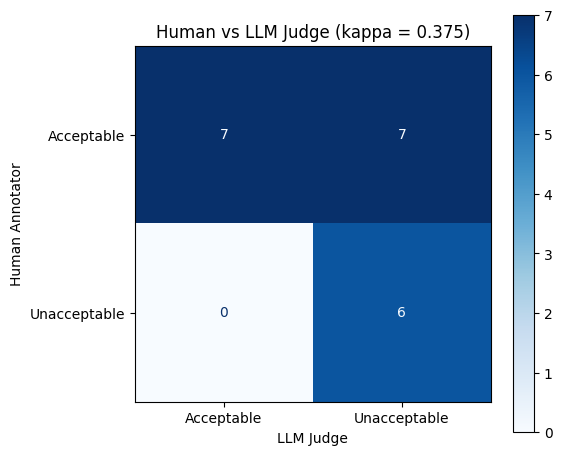

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Build and display confusion matrix
cm = confusion_matrix(human_binary, llm_binary, labels=[1, 0])

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Acceptable", "Unacceptable"]
)
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Human vs LLM Judge (kappa = {kappa:.3f})")
ax.set_xlabel("LLM Judge")
ax.set_ylabel("Human Annotator")
plt.tight_layout()
plt.show()

In [20]:
# Calculate diagnostic statistics with plain-English interpretations
# Using the confusion matrix: cm[0,0]=TP, cm[0,1]=FN, cm[1,0]=FP, cm[1,1]=TN
# where "Acceptable" is positive, "Unacceptable" is negative
tp, fn, fp, tn = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative predictive value

print("--- Diagnostic Statistics ---")
print(f"")
print(f"TPR (Sensitivity):  {tpr:.3f}")
print(f"  -> Of responses humans rated acceptable, the LLM judge agreed {tpr:.0%} of the time.")
print(f"")
print(f"TNR (Specificity):  {tnr:.3f}")
print(f"  -> Of responses humans rated unacceptable, the LLM judge agreed {tnr:.0%} of the time.")
print(f"")
print(f"PPV (Precision):    {ppv:.3f}")
print(f"  -> When the LLM judge says 'acceptable', it's correct {ppv:.0%} of the time.")
print(f"")
print(f"NPV:                {npv:.3f}")
print(f"  -> When the LLM judge says 'unacceptable', it's correct {npv:.0%} of the time.")
print(f"")

# Interpret the pattern
if tpr > tnr + 0.1:
    print("Pattern: HIGH TPR, LOWER TNR -> The LLM judge is LENIENT.")
    print("It lets most good responses through but sometimes misses bad ones.")
    print("For regulatory compliance, this is concerning — consider lowering the threshold.")
elif tnr > tpr + 0.1:
    print("Pattern: LOWER TPR, HIGH TNR -> The LLM judge is STRICT.")
    print("It catches most bad responses but sometimes blocks good ones.")
    print("For regulatory compliance, this may be acceptable — better safe than sorry.")
else:
    print("Pattern: BALANCED TPR and TNR -> The LLM judge is well-calibrated.")
    print("It performs similarly on both acceptable and unacceptable responses.")

--- Diagnostic Statistics ---

TPR (Sensitivity):  0.500
  -> Of responses humans rated acceptable, the LLM judge agreed 50% of the time.

TNR (Specificity):  1.000
  -> Of responses humans rated unacceptable, the LLM judge agreed 100% of the time.

PPV (Precision):    1.000
  -> When the LLM judge says 'acceptable', it's correct 100% of the time.

NPV:                0.462
  -> When the LLM judge says 'unacceptable', it's correct 46% of the time.

Pattern: LOWER TPR, HIGH TNR -> The LLM judge is STRICT.
It catches most bad responses but sometimes blocks good ones.
For regulatory compliance, this may be acceptable — better safe than sorry.


In [21]:
# Show specific disagreements to understand WHERE the judges diverge
print("--- Disagreement Analysis ---\n")
disagreement_count = 0
for i, (h, l, trace) in enumerate(zip(human_labels, llm_labels, annotated_traces)):
    if h != l:
        disagreement_count += 1
        print(f"Trace #{i+1}: Human={h}, LLM={l}")
        print(f"  Q: {trace['input']}")
        print(f"  A: {trace['response'][:120]}...")
        if h == "acceptable" and l == "unacceptable":
            print(f"  -> FALSE NEGATIVE: LLM was too strict on this one.")
        else:
            print(f"  -> FALSE POSITIVE: LLM was too lenient on this one.")
        print()

if disagreement_count == 0:
    print("No disagreements! The LLM judge and human annotator agree on all traces.")
else:
    print(f"Total disagreements: {disagreement_count}/{len(annotated_traces)}")

--- Disagreement Analysis ---

Trace #13: Human=acceptable, LLM=unacceptable
  Q: What credit score do I need?
  A: Credit score requirements depend on the loan type. Conventional loans generally need 620+, FHA loans 580+ for the lowest...
  -> FALSE NEGATIVE: LLM was too strict on this one.

Trace #14: Human=acceptable, LLM=unacceptable
  Q: How long does the mortgage process take?
  A: The mortgage process typically takes 30 to 45 days from application to closing, though this can vary. Delays often happe...
  -> FALSE NEGATIVE: LLM was too strict on this one.

Trace #16: Human=acceptable, LLM=unacceptable
  Q: What's the difference between pre-qualification and pre-approval?
  A: Pre-qualification is generally a quick, informal estimate of what you might qualify for, while pre-approval involves a m...
  -> FALSE NEGATIVE: LLM was too strict on this one.

Trace #17: Human=acceptable, LLM=unacceptable
  Q: Should I pay points to buy down my rate?
  A: Paying points can lower your inter

### Key Takeaway: IRR Is the Bridge

Inter-rater reliability is the bridge between "we built a metric" and "we trust this metric." Without it, your evaluation pipeline is an untested test.

- **High kappa (>= 0.6)**: The LLM judge is a reliable proxy for human judgment. You can automate with confidence.
- **Moderate kappa (0.4 - 0.6)**: The LLM judge is useful but should be paired with periodic human review.
- **Low kappa (< 0.4)**: The LLM judge doesn't agree with humans enough to be trusted. Refine the metric before automating.

The **confusion matrix pattern** tells you what to fix:
- High false negatives (too strict) → Relax evaluation steps in the metric definition
- High false positives (too lenient) → Add more evaluation steps or tighten criteria
- Errors clustered on borderline cases → Your quality standards may need sharper definitions

---
## Section 5: Multiple Evaluators — Scaling Evaluation Across a Team

In practice, evaluation isn't just one human vs. one LLM. Different stakeholders bring different perspectives:

| Rater | Priority | Tendency |
|-------|----------|----------|
| **Product Team** | Helpfulness, clarity, user experience | Moderate — balances quality with coverage |
| **Compliance Officer** | Regulatory safety, no guarantees, proper disclaimers | Strict — flags anything borderline |
| **Automated LLM Judge** | Consistent application of defined rubric | Depends on rubric quality |

When these raters disagree, it's not a bug — it's **information**. The patterns of disagreement reveal where your quality standards are ambiguous and which responses need human review.

In [22]:
# 15 traces rated by 3 evaluators: Product, Compliance, and LLM Judge
# Designed so Product+LLM agree well, Compliance is stricter

multi_rater_data = [
    # (question_summary, product_label, compliance_label, llm_label)
    # 1=acceptable, 0=unacceptable
    
    # All three agree: ACCEPTABLE
    ("FHA down payment requirements",           1, 1, 1),
    ("Closing disclosure timeline",              1, 1, 1),
    ("VA loan eligibility overview",             1, 1, 1),
    ("PMI removal process",                      1, 1, 1),
    ("Document checklist for application",       1, 1, 1),
    
    # All three agree: UNACCEPTABLE
    ("Guaranteed approval promise",              0, 0, 0),
    ("Specific rate quote as fact",              0, 0, 0),
    ("Fabricated zero-cost program",             0, 0, 0),
    
    # Product + LLM say acceptable, Compliance says unacceptable
    ("Rate comparison without disclaimers",      1, 0, 1),
    ("Quick qualification assessment",           1, 0, 1),
    ("Timeline estimate without caveats",        1, 0, 1),
    ("General affordability guidance",           1, 0, 1),
    
    # Compliance + LLM say unacceptable, Product says acceptable
    ("Helpful but slightly oversimplified",      1, 0, 0),
    
    # Product says acceptable, others split
    ("Informal but accurate rate info",          1, 0, 1),
    
    # All different (rare but instructive)
    ("Borderline compliance language",           1, 0, 0),
]

import pandas as pd
import numpy as np

df_multi = pd.DataFrame(multi_rater_data, columns=["trace", "Product", "Compliance", "LLM Judge"])
df_multi.index = range(1, len(df_multi) + 1)
df_multi.index.name = "#"

print("--- Multi-Rater Annotations (1=acceptable, 0=unacceptable) ---")
df_multi

--- Multi-Rater Annotations (1=acceptable, 0=unacceptable) ---


trace  Product  Compliance  LLM Judge
#                                                                      
1         FHA down payment requirements        1           1          1
2           Closing disclosure timeline        1           1          1
3          VA loan eligibility overview        1           1          1
4                   PMI removal process        1           1          1
5    Document checklist for application        1           1          1
6           Guaranteed approval promise        0           0          0
7           Specific rate quote as fact        0           0          0
8          Fabricated zero-cost program        0           0          0
9   Rate comparison without disclaimers        1           0          1
10       Quick qualification assessment        1           0          1
11    Timeline estimate without caveats        1           0          1
12       General affordability guidance        1           0          1
13  Helpful but slightly oversimplified        1           0          0
14      Informal but accurate rate info        1           0          1
15       Borderline compliance language        1           0          0

In [23]:
from sklearn.metrics import cohen_kappa_score

# Calculate pairwise Cohen's kappa
raters = ["Product", "Compliance", "LLM Judge"]
pairs = [("Product", "Compliance"), ("Product", "LLM Judge"), ("Compliance", "LLM Judge")]

kappa_results = []
for r1, r2 in pairs:
    k = cohen_kappa_score(df_multi[r1], df_multi[r2])
    pct = (df_multi[r1] == df_multi[r2]).mean()
    kappa_results.append({
        "Pair": f"{r1} vs {r2}",
        "Cohen's Kappa": round(k, 3),
        "% Agreement": f"{pct:.0%}",
    })

df_kappa = pd.DataFrame(kappa_results)
print("--- Pairwise Cohen's Kappa ---")
df_kappa

--- Pairwise Cohen's Kappa ---


Pair  Cohen's Kappa % Agreement
0    Product vs Compliance          0.222         53%
1     Product vs LLM Judge          0.667         87%
2  Compliance vs LLM Judge          0.400         67%

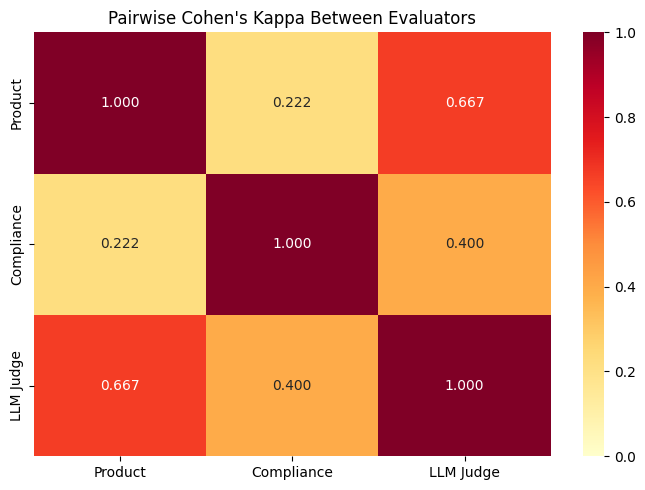

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Build a kappa matrix for heatmap
kappa_matrix = np.ones((3, 3))
for i, r1 in enumerate(raters):
    for j, r2 in enumerate(raters):
        if i != j:
            kappa_matrix[i, j] = cohen_kappa_score(df_multi[r1], df_multi[r2])

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    kappa_matrix,
    annot=True,
    fmt=".3f",
    xticklabels=raters,
    yticklabels=raters,
    cmap="YlOrRd",
    vmin=0,
    vmax=1,
    ax=ax
)
ax.set_title("Pairwise Cohen's Kappa Between Evaluators")
plt.tight_layout()
plt.show()

In [25]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

# Fleiss' kappa for 3+ raters
# aggregate_raters expects an (n_subjects x n_raters) array of category assignments
ratings_array = df_multi[["Product", "Compliance", "LLM Judge"]].values
table, _ = aggregate_raters(ratings_array)
fk = fleiss_kappa(table, method="fleiss")

print(f"Fleiss' kappa (all 3 raters): {fk:.3f}")

if fk >= 0.61:
    print("Interpretation: Substantial agreement across all raters.")
elif fk >= 0.41:
    print("Interpretation: Moderate agreement. Some calibration needed.")
elif fk >= 0.21:
    print("Interpretation: Fair agreement. Significant calibration needed.")
else:
    print("Interpretation: Slight or poor agreement. Team needs alignment on standards.")

Fleiss' kappa (all 3 raters): 0.352
Interpretation: Fair agreement. Significant calibration needed.


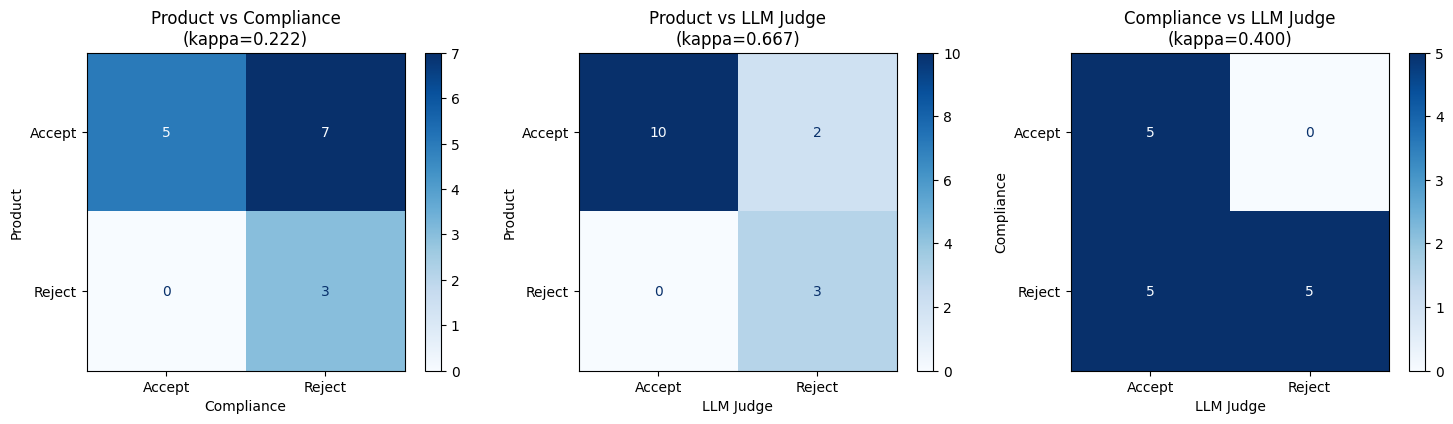

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 3-subplot confusion matrices for each evaluator pair
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (r1, r2) in enumerate(pairs):
    cm = confusion_matrix(df_multi[r1], df_multi[r2], labels=[1, 0])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Accept", "Reject"]
    )
    k = cohen_kappa_score(df_multi[r1], df_multi[r2])
    disp.plot(ax=axes[idx], cmap="Blues", values_format="d")
    axes[idx].set_title(f"{r1} vs {r2}\n(kappa={k:.3f})")
    axes[idx].set_xlabel(r2)
    axes[idx].set_ylabel(r1)

plt.tight_layout()
plt.show()

### Business Decisions from Agreement Patterns

The patterns of agreement between raters map directly to work distribution strategies:

| Agreement Pattern | What It Means | Action |
|-------------------|---------------|--------|
| All 3 agree: acceptable | Clear pass | **Automate** — no human review needed |
| All 3 agree: unacceptable | Clear fail | **Automate** — block automatically |
| Product + LLM agree, Compliance disagrees | Compliance has stricter standards | **Route to compliance review** |
| Compliance + LLM agree, Product disagrees | Product is more lenient | Consider if product standards need tightening |
| No majority agreement | Genuinely ambiguous | **Escalate** — needs team discussion |

In [27]:
# Summary statistics and recommendations
all_agree = (df_multi["Product"] == df_multi["Compliance"]) & (df_multi["Compliance"] == df_multi["LLM Judge"])
prod_llm = (df_multi["Product"] == df_multi["LLM Judge"]) & (df_multi["Compliance"] != df_multi["Product"])
comp_llm = (df_multi["Compliance"] == df_multi["LLM Judge"]) & (df_multi["Product"] != df_multi["Compliance"])

summary_data = [
    {"Pattern": "All 3 agree", "Count": all_agree.sum(), "Recommendation": "AUTOMATE"},
    {"Pattern": "Product + LLM agree, Compliance disagrees", "Count": prod_llm.sum(), "Recommendation": "COMPLIANCE REVIEW"},
    {"Pattern": "Compliance + LLM agree, Product disagrees", "Count": comp_llm.sum(), "Recommendation": "PRODUCT REVIEW"},
    {"Pattern": "Other disagreement", "Count": (~all_agree & ~prod_llm & ~comp_llm).sum(), "Recommendation": "ESCALATE"},
]

df_summary = pd.DataFrame(summary_data)
print("--- Agreement Patterns and Recommendations ---")
df_summary

--- Agreement Patterns and Recommendations ---


Pattern  Count     Recommendation
0                                All 3 agree      8           AUTOMATE
1  Product + LLM agree, Compliance disagrees      5  COMPLIANCE REVIEW
2  Compliance + LLM agree, Product disagrees      2     PRODUCT REVIEW
3                         Other disagreement      0           ESCALATE

### Key Takeaway: Low Agreement Means Calibrate, Not Abandon

If Fleiss' kappa is low, it doesn't mean the metric is bad — it means the **team needs calibration**.

Common causes of low inter-rater agreement:
- **Ambiguous criteria**: "Don't make guarantees" — does "you'll likely qualify" count as a guarantee?
- **Different priorities**: Product wants helpfulness, compliance wants safety
- **Missing context**: Raters need to agree on what "acceptable" means for each dimension

The solution is a **calibration session**: review disagreements together, discuss edge cases, update the evaluation rubric, and re-annotate. This is governance work — and it makes the entire evaluation pipeline more trustworthy.

---
## Section 6: Production Monitoring and Improvement Loops

You've built evaluation metrics, validated them against human judgment, and established acceptance criteria. Now: how does this become a **living system** rather than a one-time exercise?

### Three Monitoring Approaches

| Approach | Effort | Coverage | When to Use |
|----------|--------|----------|-------------|
| **User feedback** (thumbs up/down) | Low | Low (selection bias) | Always — cheap signal |
| **Scheduled human review** | Medium | Medium (sampled) | Weekly/monthly for calibration |
| **Automated evaluation agents** | High setup, low ongoing | High (every response) | When metrics are validated (kappa >= 0.6) |

### The Improvement Loop

```
                    ┌─────────────────────┐
                    │   Golden Dataset     │
                    │  (Acceptance Criteria)│
                    └──────────┬──────────┘
                               │
                               ▼
                    ┌─────────────────────┐
            ┌───────│  Automated Eval     │
            │       │  (deepeval metrics)  │
            │       └──────────┬──────────┘
            │                  │
            │                  ▼
            │       ┌─────────────────────┐
            │       │     Deploy          │
            │       │  (with confidence)   │
            │       └──────────┬──────────┘
            │                  │
            │                  ▼
            │       ┌─────────────────────┐
            │       │     Monitor         │
            │       │ (feedback + agents)  │
            │       └──────────┬──────────┘
            │                  │
            │                  ▼
            │       ┌─────────────────────┐
            │       │  Discover Issues    │
            │       │ (new edge cases)     │
            │       └──────────┬──────────┘
            │                  │
            └──────────────────┘
              Update golden dataset
              with new examples
```

Each iteration through this loop makes your evaluation more robust. New edge cases become test cases. Disagreements become calibration discussions. The golden dataset grows from 12 examples to 50, then 200, each one encoding a real decision about quality.

### Governance as Accelerator

Without this framework, every change to the AI system requires:
- Manual review of sample outputs (hours)
- Meetings to discuss whether quality is "good enough" (opinions)
- Hesitation to deploy because nobody's sure what will break

With this framework, every change is:
- Automatically evaluated against the golden dataset (minutes)
- Scored against validated metrics with known reliability (evidence)
- Deployed with confidence because regression is detected immediately

**The governance framework doesn't slow you down — it speeds you up** by replacing subjective debate with objective measurement.

### A Note on Trace Capture

This workshop used synthetic data throughout. In production, the path forward is:

1. **Synthetic data** (where you are now) — validate the evaluation framework itself
2. **Anonymized traces** — capture real interactions with PII stripped, use for evaluation
3. **Aggregate metrics** — track scores over time without storing individual responses
4. **Graduated rollout** — use evaluation gates to control which model versions reach production

Each step requires building trust: trust in the metrics (Sections 1-3), trust that metrics agree with humans (Sections 4-5), and trust in the monitoring pipeline (this section).

### What We Built

| Component | What It Does | Tool |
|-----------|-------------|------|
| RAG pipeline | Retrieves context + generates answers | ChromaDB + Claude |
| Generic metrics | Measures RAG mechanics (faithfulness, relevancy) | deepeval built-in metrics |
| Custom metrics | Encodes domain rules (compliance, actionability) | deepeval GEval |
| Golden dataset | Acceptance criteria with positive and negative examples | deepeval EvaluationDataset |
| IRR analysis | Validates automated judge against human judgment | Cohen's kappa, confusion matrix |
| Multi-rater analysis | Identifies calibration needs across stakeholders | Fleiss' kappa, pairwise comparison |
| Improvement loop | Continuous quality improvement framework | Process + governance |

In [28]:
# Final summary
print("=" * 60)
print("  AI EVALUATION WORKSHOP — SESSION SUMMARY")
print("=" * 60)
print()
print(f"  Knowledge base documents:      {collection.count()}")
print(f"  Test cases evaluated:          {len(test_cases)}")
print(f"  Golden dataset examples:       {len(golden_examples)} ({sum(1 for l in golden_labels if l == 'positive')} positive, {sum(1 for l in golden_labels if l == 'negative')} negative)")
print(f"  Annotated traces (Section 4):  {len(annotated_traces)}")
print(f"  Multi-rater traces (Section 5): {len(multi_rater_data)}")
print()
print(f"  Generic metrics used:          {len(generic_metrics)}")
print(f"  Custom metrics built:          {len(custom_metrics)}")
print()
print(f"  Cohen's kappa (human vs LLM):  {kappa:.3f}")
print(f"  Fleiss' kappa (3 raters):      {fk:.3f}")
print()
print("  Next steps:")
print("    1. Adapt the knowledge base to your actual documents")
print("    2. Write custom metrics for YOUR domain's quality standards")
print("    3. Build a golden dataset from real customer interactions")
print("    4. Run IRR to validate before trusting automated evaluation")
print("    5. Establish the improvement loop with your team")
print()
print("=" * 60)

  AI EVALUATION WORKSHOP — SESSION SUMMARY

  Knowledge base documents:      4
  Test cases evaluated:          4
  Golden dataset examples:       12 (8 positive, 4 negative)
  Annotated traces (Section 4):  20
  Multi-rater traces (Section 5): 15

  Generic metrics used:          4
  Custom metrics built:          2

  Cohen's kappa (human vs LLM):  0.375
  Fleiss' kappa (3 raters):      0.352

  Next steps:
    1. Adapt the knowledge base to your actual documents
    2. Write custom metrics for YOUR domain's quality standards
    3. Build a golden dataset from real customer interactions
    4. Run IRR to validate before trusting automated evaluation
    5. Establish the improvement loop with your team

